# Random Forest and Adaboost Models

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data and Final Preprocessing

In [3]:
data = pd.read_csv("../data/cleaned_data.csv")
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,total_sqft,total_sqft15
0,7129300520,221900,3,1.00,1180,5650,1.0,0,0,3,...,98178,47.5112,-122.257,1340,5650,2014,10,13,6830,6990
1,6414100192,538000,3,2.25,2570,7242,2.0,0,0,3,...,98125,47.7210,-122.319,1690,7639,2014,12,9,9812,9329
2,5631500400,180000,2,1.00,770,10000,1.0,0,0,3,...,98028,47.7379,-122.233,2720,8062,2015,2,25,10770,10782
3,2487200875,604000,4,3.00,1960,5000,1.0,0,0,5,...,98136,47.5208,-122.393,1360,5000,2014,12,9,6960,6360
4,1954400510,510000,3,2.00,1680,8080,1.0,0,0,3,...,98074,47.6168,-122.045,1800,7503,2015,2,18,9760,9303


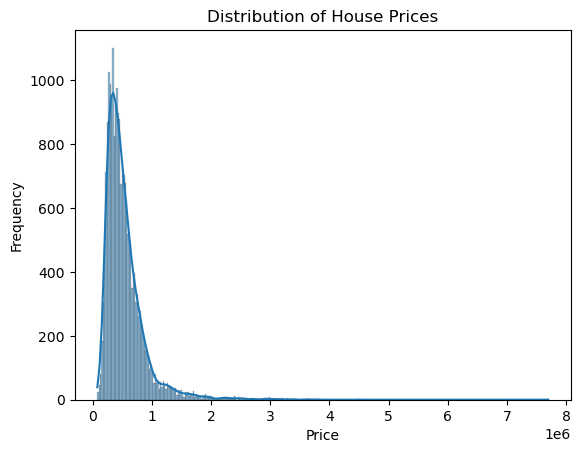

In [4]:
# Analyzing The Target Variable "price"
sns.histplot(data.price, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The distribution above is right-skewed which means most prices are in the lower range. A logarithmic transformation to the price will make the distribution closer to normal which usually improves model performance.

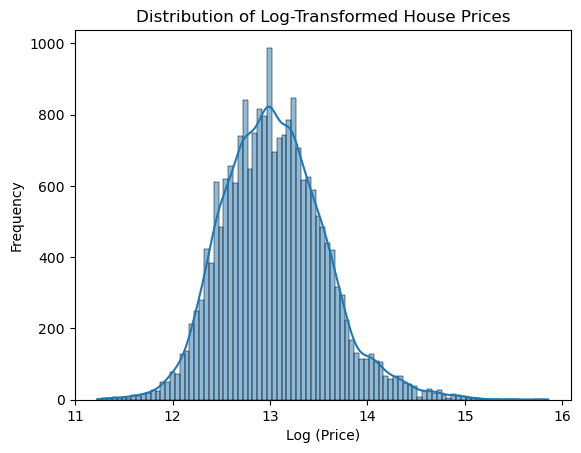

In [5]:
data["log_price"] = np.log(data.price)
sns.histplot(data.log_price, kde=True)
plt.title("Distribution of Log-Transformed House Prices")
plt.xlabel("Log (Price)")
plt.ylabel("Frequency")
plt.show()

In [6]:
data = data.drop(columns=["price","id", "lat", "long", "waterfront", "view", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15", "year", "month", "day", "total_sqft", "total_sqft15"])
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,log_price
0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,0,12.309982
1,3,2.25,2570,7242,2.0,3,7,2170,400,1951,1991,13.195614
2,2,1.00,770,10000,1.0,3,6,770,0,1933,0,12.100712
3,4,3.00,1960,5000,1.0,5,7,1050,910,1965,0,13.311329
4,3,2.00,1680,8080,1.0,3,8,1680,0,1987,0,13.142166


## Data Split

In [7]:
X = data.drop(columns=["log_price"]) # Features
y = data["log_price"] # Target variable

# Splitting data to training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=371)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((17013, 11), (4254, 11), (17013,), (4254,))

## Models and Analysis

### Random Forest

#### Initial Model

In [8]:
# Training
rf_model = RandomForestRegressor(random_state=371)
rf_model.fit(X_train_scaled, y_train)

# Predicting with the test data
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluating the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

rf_mae, rf_rmse, rf_r2

(0.23084514628602798, 0.3015529261811378, 0.6798185066476796)

In [9]:
rf_model.score(X_train_scaled, y_train)

0.9524946892355453

In [10]:
rf_model.score(X_test_scaled, y_test)

0.6798185066476796

The initial random forest model has a **moderate performance** in predicting the price.

1. Mean absolute error (MAE): 0.231
2. Root Mean Squared Error (RMSE): 0.302
3. R²: 0.680

#### Feature Importances

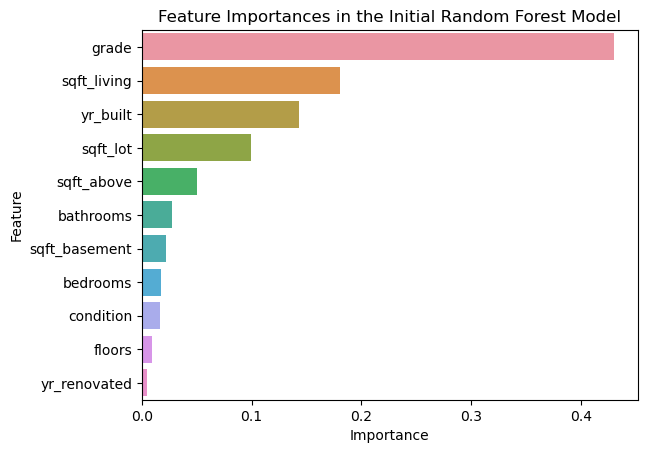

In [11]:
# Finding importances of each feature
feature_importances_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Plotting importances
sns.barplot(data=feature_importances_rf, x="importance", y="feature")
plt.title("Feature Importances in the Initial Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [12]:
feature_importances_rf

,feature,importance
6,grade,0.430520
2,sqft_living,0.180319
9,yr_built,0.143082
3,sqft_lot,0.099680
7,sqft_above,0.049848
1,bathrooms,0.027410
8,sqft_basement,0.021699
0,bedrooms,0.017017
5,condition,0.016151
4,floors,0.009316


The feature importance analysis of the initial model reveals that the most influential features in predicting price are:

1. "grade": 0.431 
2. "sqft_living": 0.180 
3. "yr_built": 0.143

These features play a significant role in determining house prices, as indicated by their higher importance values in the model.

#### Hyperparameter Tuning

In [32]:
# Parameter distribution
param_dist = {
    "n_estimators": sp_randint(50, 200),
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 5)
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=370),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=2)

# Fit Randomized Search
random_search.fit(X_train_scaled, y_train)

# Best Parameters
best_params_rf = random_search.best_params_
best_params_rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 180}

The randomized search with cross-validation searched for the best combination of hyperparameters within specified ranges in the param_dist to find the best hyperparameters, which are:

* "max_depth": 30
* "min_samples_leaf": 4
* "min_samples_split": 10
* "n_estimators": 180

It is expected that these hyperparameters result in a higher predictive performance than the initial model.

#### Model Retraining and Evaluation

In [13]:
# To avoid running the hyperparameter tuning over and over
best_params_rf = {"max_depth": 30, "min_samples_leaf": 4, "min_samples_split": 10, "n_estimators": 180}

# Re-training the model
tuned_model = RandomForestRegressor(**best_params_rf, random_state=371)
tuned_model.fit(X_train_scaled, y_train)

# Predict on the test set
tuned_predictions = tuned_model.predict(X_test_scaled)

# Evaluate the tuned model
tuned_mae = mean_absolute_error(y_test, tuned_predictions)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_predictions))
tuned_r2 = r2_score(y_test, tuned_predictions)

tuned_mae, tuned_rmse, tuned_r2

(0.22991398934859747, 0.29969647122331994, 0.6837486482882182)

In [14]:
tuned_model.score(X_train_scaled, y_train)

0.849152185518686

In [15]:
tuned_model.score(X_test_scaled, y_test)

0.6837486482882182

In [16]:
mae_difference = tuned_mae - rf_mae
rmse_difference = tuned_rmse - rf_rmse
r2_difference = tuned_r2 - rf_r2

mae_difference, rmse_difference, r2_difference

(-0.0009311569374305106, -0.001856454957817888, 0.00393014164053862)

The tuned random forest model shows a **slightly improved performance** compared to the initial model.

* Mean absolute error (MAE): Approximately 0.2299. **Lower by about 0.0009** from initial model.
* Root mean squared error (RMSE): Approximately 0.2997. **Lower by about 0.0019** from initial model.
* R²: Approximately 0.6837. **Higher by about 0.039** from initial model.

These results indicate the tuned model provides a slightly better fit to the data and improved predictive accuracy compared to the initial model.

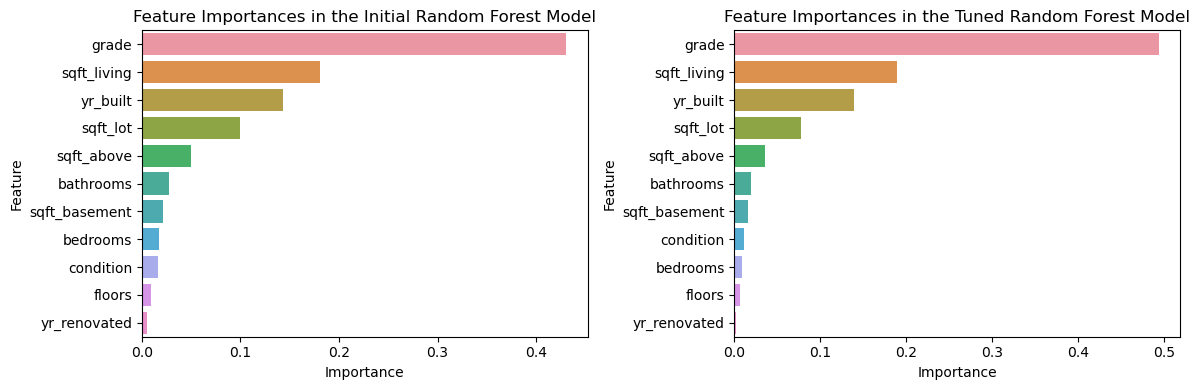

In [17]:
# Feature Importance Analysis
feature_importances_rf_tuned = pd.DataFrame({
    "feature": X.columns,
    "importance": tuned_model.feature_importances_
}).sort_values(by='importance', ascending=False)


# Plotting the Intial and Tuned Model Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=feature_importances_rf, x="importance", y="feature", ax=axes[0])
axes[0].set_title("Feature Importances in the Initial Random Forest Model")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

sns.barplot(data=feature_importances_rf_tuned, x="importance", y="feature", ax=axes[1])
axes[1].set_title("Feature Importances in the Tuned Random Forest Model")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

In [18]:
feature_importances_rf, feature_importances_rf_tuned

(          feature  importance
 6           grade    0.430520
 2     sqft_living    0.180319
 9        yr_built    0.143082
 3        sqft_lot    0.099680
 7      sqft_above    0.049848
 1       bathrooms    0.027410
 8   sqft_basement    0.021699
 0        bedrooms    0.017017
 5       condition    0.016151
 4          floors    0.009316
 10   yr_renovated    0.004957,
           feature  importance
 6           grade    0.494281
 2     sqft_living    0.189468
 9        yr_built    0.139803
 3        sqft_lot    0.077287
 7      sqft_above    0.035412
 1       bathrooms    0.019180
 8   sqft_basement    0.015852
 5       condition    0.010898
 0        bedrooms    0.009416
 4          floors    0.006106
 10   yr_renovated    0.002297)

In the tuned model, "grade" remains the most important feature, followed by "sqft_living" and "yr_built," with importance values of approximately 0.494, 0.189, and 0.140. Notably, the tuned model slightly increases the importance of "grade" and "sqft_living", while reducing importance of all others.

### Adaboost

#### Initial Model

In [19]:
# Training the AdaBoost model
ab_model = AdaBoostRegressor(random_state=42)
ab_model.fit(X_train_scaled, y_train)

# Predicting on the test set
ab_predictions = ab_model.predict(X_test_scaled)

# Evaluating the AdaBoost model
ab_mae = mean_absolute_error(y_test, ab_predictions)
ab_mse = mean_squared_error(y_test, ab_predictions)
ab_rmse = np.sqrt(ab_mse)
ab_r2 = r2_score(y_test, ab_predictions)

ab_mae, ab_rmse, ab_r2

(0.2760316208603992, 0.34267091110972014, 0.5865494154530719)

In [20]:
ab_model.score(X_train_scaled, y_train)

0.5779408866690485

In [21]:
ab_model.score(X_test_scaled, y_test)

0.5865494154530719

The initial AdaBoost performace:

1. Mean Absolute Error (MAE): 0.276
2. Root Mean Squared Error (RMSE): 0.343
3. R² (R-squared): 0.587

The AdaBoost model shows satisfactory performance. It has a higher MAE, RMSE, and a lower R² compared to the initial random forest models, suggesting the random forest model may initially outperform AdaBoost in this context. Random Forest's are known for its higher accuracy (in comparison to other models) so this result was expected

#### Feature Importances

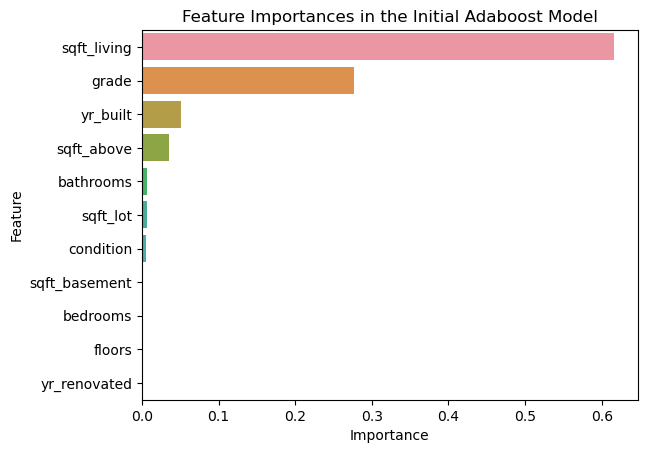

In [22]:
# Analyzing feature importance in the initial Adaboost model
feature_importances_ab = pd.DataFrame({
    "feature": X.columns,
    "importance": ab_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Plotting the feature importances
sns.barplot(data=feature_importances_ab, x="importance", y="feature")
plt.title("Feature Importances in the Initial Adaboost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [23]:
feature_importances_ab

,feature,importance
2,sqft_living,0.616417
6,grade,0.276711
9,yr_built,0.051109
7,sqft_above,0.035777
1,bathrooms,0.006250
3,sqft_lot,0.006238
5,condition,0.005666
8,sqft_basement,0.001105
0,bedrooms,0.000726
4,floors,0.000000


The initial AdaBoost model's feature importance analysis reveals the importance scores:

1. "sqft_living": 0.616
2. "grade": 0.276
3. "yr_built": 0.051

"sqft_living" is the most influential predictor, followed by "grade" and "yr_built." Several features have no importance: "floors" and "yr_renovated" which indicate their limited contribution to predicting house prices in this model.

#### Hyperparameter Tuning

In [50]:
param_dist_ab = {
    "n_estimators": sp_randint(30, 200),
    "learning_rate": uniform(0.01, 1)
}

# Randomized Search with Cross-Validation
random_search_ab = RandomizedSearchCV(estimator=AdaBoostRegressor(random_state=370),
                                      param_distributions=param_dist_ab,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1,
                                      random_state=371,
                                      verbose=2)

random_search_ab.fit(X_train_scaled, y_train)

# Best Parameters
best_params_ab = random_search_ab.best_params_
best_params_ab

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'learning_rate': 0.47573516616334455, 'n_estimators': 39}

Randomized Search with Cross-Validation for hyperparameter tuning of the AdaBoostRegressor found the best parameters:

* Number of Estimators (n_estimators): 39
* Learning Rate (learning_rate): 0.476

#### Model Retraining and Evaluation

In [24]:
# To avoid running the hyperparameter tuning over and over
best_params_ab = {"learning_rate": 0.47573516616334455, "n_estimators": 39}

# Retrain model
tuned_ab_model = AdaBoostRegressor(**best_params_ab, random_state=371)
tuned_ab_model.fit(X_train_scaled, y_train)

# Predict on the test set
tuned_ab_predictions = tuned_ab_model.predict(X_test_scaled)

# Evaluate the tuned model
tuned_ab_mae = mean_absolute_error(y_test, tuned_ab_predictions)
tuned_ab_rmse = np.sqrt(mean_squared_error(y_test, tuned_ab_predictions))
tuned_ab_r2 = r2_score(y_test, tuned_ab_predictions)

tuned_ab_mae, tuned_ab_rmse, tuned_ab_r2

(0.27558613305236274, 0.3410183329469718, 0.5905276454603715)

In [25]:
tuned_ab_model.score(X_train_scaled, y_train)

0.5840689908046867

In [26]:
tuned_ab_model.score(X_test_scaled, y_test)

0.5905276454603715

In [27]:
mae_difference = tuned_ab_mae - ab_mae
rmse_difference = tuned_ab_rmse - ab_rmse
r2_difference = tuned_ab_r2 - ab_r2

mae_difference, rmse_difference, r2_difference

(-0.0004454878080364377, -0.0016525781627483305, 0.003978230007299577)

The tuned AdaBoost model shows a **slightly higher performance** compared to the initial model.

* Mean Absolute Error (MAE): Approximately 0.2756. **Lower by about 0.0004** from the initial model.
* Root Mean Squared Error (RMSE): Approximately 0.3410. **Lower by about 0.0017** from the initial model.
* R²: Approximately 0.5905. **Higher by about 0.0039** from the initial model.

These results indicate that the tuned model provides slightly better predictive performance compared to the initial model.

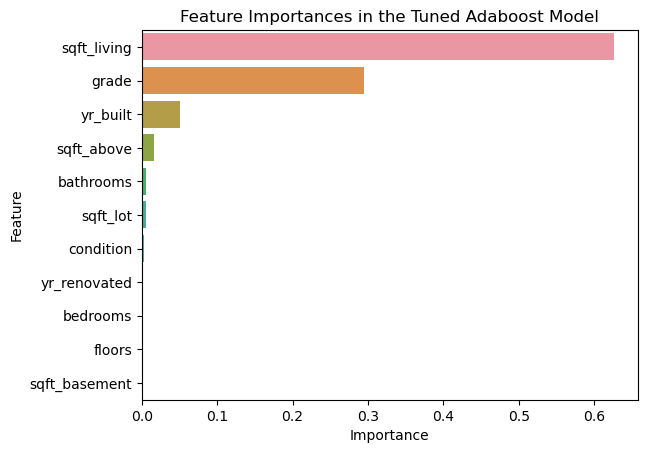

In [28]:
# Feature Importance Analysis
feature_importances_ab_tuned = pd.DataFrame({
    "feature": X.columns,
    'importance': tuned_ab_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plotting the feature importances
sns.barplot(data=feature_importances_ab_tuned, x="importance", y="feature")
plt.title("Feature Importances in the Tuned Adaboost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [29]:
feature_importances_ab_tuned

,feature,importance
2,sqft_living,0.626629
6,grade,0.294077
9,yr_built,0.051039
7,sqft_above,0.015435
1,bathrooms,0.005120
3,sqft_lot,0.005106
5,condition,0.002316
10,yr_renovated,0.000279
0,bedrooms,0.000000
4,floors,0.000000


The tuned AdaBoost model's feature importance differs from the initial AdaBoost feature importance by placing slightly more importance on "sqft_living" and "grade" while reducing the importance of other features.

## Conclusion

The Random Forest model performed moderately well initially, with a mean absolute error (MAE) of 0.231, root mean squared error (RMSE) of 0.302, and an R² of 0.680. Its performance slightly improved after hyperparameter tuning, seen by a small decrease in MAE and RMSE, and a slight increase in R². The feature importance analysis revealed "grade," "sqft_living," and "yr_built" as the most influential features, with their importance becoming more pronounced in the tuned model.

The AdaBoost model initially had a higher MAE and RMSE and a lower R² compared to the Random Forest. Like the Random Forest, the AdaBoost model showed a slight improvement in performance after hyperparameter tuning. The feature importance analysis for AdaBoost highlighted "sqft_living," "grade," and "yr_built" as key predictors, with a noticeable emphasis on "sqft_living."

Both models concluded that certain features are most influencial in predicting house prices, with "grade" and "sqft_living" being significant across both models. While the Random Forest model edged out in performance, the AdaBoost model also showed its slim improvement after tuning.